In [1]:
import numpy as np
import galois
import hashlib
import matplotlib.pyplot as plt

from itertools import permutations

---
# base functions

In [105]:
# Obtain minimal gap between adyacent values for sequence X
def get_min_gap(X):
    gap = np.inf
    q = len(X)

    for i in range(q):

        d = abs(X[(i+1) % q] - X[i])

        if d < gap:
            gap = d

    return gap


# Transform number n to base b
def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]


# hamming correlation with shift 0 for sequences
# u and v with the same length (assumed)
def hamming_correlation(u,v):
    u_eq_v = u == v
    return u_eq_v.sum()

# maximal hamming correlation for sequences
# u and v with the same length (assumed)
def maxHC(u,v):

    start = 0
    if np.array_equal(u,v): start = 1

    current_maxHC = 0
    for shift in range(start, len(u)):

        hc = hamming_correlation(u, np.roll(v, shift))
        
        if hc > current_maxHC:
            current_maxHC = hc
    
    return current_maxHC


# average hamming auto correlation for a family of
# sequences with the same length (assumed)
def avg_autoHC(fam):
    _avgHC = 0
    M, L = fam.shape
    for i in range(M):
        for shift in range(1, L):
            _avgHC += hamming_correlation(fam[i], np.roll(fam[i], shift))

    return _avgHC / (M * (L-1))


# average hamming cross correlation for a family of
# sequences with the same length (assumed)
def avg_crossHC(fam):
    _avgHC = 0
    M, L = fam.shape
    for i in range(M):
        for j in range(i):
            for shift in range(L):
                _avgHC += hamming_correlation(fam[i], np.roll(fam[j], shift))

    n = M * (M-1) / 2
    return _avgHC / (L*n)


# average maximal hamming correlation for all paris of
# sequences from a single family
def avg_maxHC(fam):
    mean = 0
    s = len(fam)
    for i in range(s):
        for j in range(i+1):
            mean += maxHC(fam[i], fam[j])

    n = s * (s+1) / 2
    return mean / n


# average maximal hamming correlation for all paris of
# sequences from two families
def avg_maxHC_2fam(fam1, fam2):
    mean = 0
    s = len(fam1)
    for i in range(s):
        for j in range(s):
            mean += maxHC(fam1[i], fam2[j])
        
    n = s**2
    return mean / n

---
# 1st method (family)

Generates a family of sequences with optimal maximal hammig correlation from a single m-sequence

.

Generated sequences have length q = p^n - 1

over an alphabet A of size |A| = p^k

for any given prime number p

and integers k,n s.t. 1 <= k <= n

.


[1] Lempel, A., & Greenberger, H. (1974). Families of sequences with optimal Hamming-correlation properties. IEEE Transactions on Information Theory, 20(1), 90-94.


In [3]:
"""
maps a sequence X in P^k to a value in P_k
where P^k is the set of all words of length k over P
P is the finite field (GF) of order p, i.e. P = {0, 1, ..., p-1}
P_k is the finite field (GF) of order p^k, i.e. P_k = {0, 1, ..., p^k-1}
"""
def sigma_transform(X, p, k):

    Y = []
    q = len(X)
    for j in range(q):

        y_j = 0
        for i in range(k):
            y_j += X[(j+i) % q] * p**i

        Y.append(y_j)

    return Y


"""
Following the construction presented in [1]
given an m-sequence X of length q = p^n - 1 over GF(p)
where p is a prime number
then for each k s.t. 1 <= k <= n, the set F of p^k
sequences is an optimal family

a variation of the sigma transform is used
"""
def optimal_family(X, p, k):

    family = []
    q = len(X)
    for v in range(p**k):

        z = numberToBase(v, p)
        while len(z) < k:
            z.insert(0,0)
        z.reverse()

        Y = []
        for j in range(q):

            y_j = 0
            for i in range(k):
                y_j += ( ( X[ (j+i) % q] + z[i]) % p ) * p**i

            Y.append(y_j)

        family.append(Y)
        #print(f"Y{v} = ", Y)

    return np.array(family)

In [4]:
# test from [1]
# n = 3, then q = len(X) = p^n - 1 = 3^3 - 1 = 26
X = [0,0,1,1,1,0,2,1,1,2,1,0,1,0,0,2,2,2,0,1,2,2,1,2,0,2]
testfam = optimal_family(X, 3, 2)

### test for lora m = 2**5 = 32 frequencies

In [225]:
polys = galois.primitive_polys(2, 5)
poly1 = next(polys)
poly2 = next(polys)

lfsr1 = galois.GLFSR(poly1.reverse())
lfsr2 = galois.GLFSR(poly2.reverse())

In [226]:
p = 2
k = 5
n = 5
q = p**n - 1

x1 = lfsr1.step(q)

method1_fam = optimal_family(np.array(x1), p, k)
method1_fam = method1_fam *8

print(method1_fam.shape)
print(f"family avg cross HC = {round(avg_crossHC(method1_fam),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method1_fam),5)}")
print(f"family max HC = {round(avg_maxHC(method1_fam),5)}")

(32, 31)
family avg cross HC = 0.96774
family avg auto HC = 0.0
family max HC = 0.93939


In [227]:
x2 = lfsr2.step(q)

method1_fam2 = optimal_family(np.array(x2), p, k)
method1_fam2 = method1_fam2 *8

print(method1_fam2.shape)
print(f"family avg cross HC = {round(avg_crossHC(method1_fam2),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method1_fam2),5)}")
print(f"family max HC = {round(avg_maxHC(method1_fam2),5)}")

(32, 31)
family avg cross HC = 0.96774
family avg auto HC = 0.0
family max HC = 0.93939


In [228]:
method1_fam3 = np.concatenate((method1_fam, method1_fam2))

print(method1_fam3.shape)
print(f"family avg cross HC = {round(avg_crossHC(method1_fam3),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method1_fam3),5)}")
print(f"family max HC = {round(avg_maxHC(method1_fam3),5)}")

(64, 31)
family avg cross HC = 0.96825
family avg auto HC = 0.0
family max HC = 2.10769


In [229]:
method1_fam3

array([[ 56,  24, 136, ..., 240, 248, 120],
       [ 48,  16, 128, ..., 248, 240, 112],
       [ 40,   8, 152, ..., 224, 232, 104],
       ...,
       [112,  32, 136, ...,  16, 144, 208],
       [104,  56, 144, ...,   8, 136, 200],
       [ 96,  48, 152, ...,   0, 128, 192]])

---
# 2nd method (sequence)

Generates a wide gap sequence with minimum gap e and optimal maximal hamming autocorrelation

.

let X be a WGFHS of length q

over alphabet A of size |A| = l

with minimum gap e

and maximal hamming autocorrelation h

then X is defined by the parameters (q, l, h, e)
.




In [27]:
"""
let l, d s.t. 1 < d < l/2
& gcd(l, d) = gcd(l, d+1) = 1

generate an optimal WGFHS with parameters (2*l, l, 2, d-1)
"""
def get_2l_sequence(l, d):
    s = []
    t = []

    for i in range(l):
        s.append( (i*d) % l )
        t.append( (i*(d+1) + 1) % l )

    return np.array(s + t)


"""
let l, d s.t. 1 < d < (l-1)/2
& gcd(l, d) = gcd(l, d+1) = gcd(l, d+2) = 1

generate an optimal WGFHS with parameters (3*l, l, 3, d-1)
"""
def get_3l_sequence(l, d):
    s = []
    t = []
    u = []

    for i in range(l):
        s.append( (i*d) % l )
        t.append( (i*(d+1) + 1) % l )
        u.append( (i*(d+2) + 2) % l )

    return np.array(s + t + u)


# greatest common division
def gcd(a, b):
    if(b == 0): return abs(a)
    else: return gcd(b, a % b)


def split_seq(q, seq):
    family = []
    i=0
    j=q
    while j < len(seq):
        family.append(seq[i:j])
        i+=q
        j+=q

    return np.array(family)

# delete frequences above the maximum, raises error if it
# disrupts the minimum gap property
def filter_freq(seq):
    newseq = np.delete(seq, np.where(seq >= 280)[0])
    assert get_min_gap(newseq) == 8, "couldn't filter sequences while preserving minimum gap"
    return newseq


#### 3*l seq

In [83]:
l = 277
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}\tc={gcd(l, d+2)}")

x = get_3l_sequence(l, d)
method2_fam1 = split_seq(31, x)

print(method2_fam1.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam1),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam1),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam1),5)}")

a=1	b=1	c=1
(26, 31)
family avg cross HC = 0.07752
family avg auto HC = 0.0
family max HC = 0.7037


In [84]:
l = 281
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}\tc={gcd(l, d+2)}")

x = get_3l_sequence(l, d)
xx = filter_freq(x)
method2_fam2 = split_seq(31, xx)

print(method2_fam2.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam2),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam2),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam2),5)}")

a=1	b=1	c=1
(27, 31)
family avg cross HC = 0.07665
family avg auto HC = 0.0
family max HC = 0.69048


In [85]:
l = 283
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}\tc={gcd(l, d+2)}")

x = get_3l_sequence(l, d)
xx = filter_freq(x)
method2_fam3 = split_seq(31, xx)

print(method2_fam3.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam3),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam3),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam3),5)}")

a=1	b=1	c=1
(27, 31)
family avg cross HC = 0.07665
family avg auto HC = 0.0
family max HC = 0.74603


In [86]:
l = 287
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}\tc={gcd(l, d+2)}")

x = get_3l_sequence(l, d)
xx = filter_freq(x)
method2_fam4 = split_seq(31, xx)

print(method2_fam4.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam4),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam4),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam4),5)}")

a=1	b=1	c=1
(27, 31)
family avg cross HC = 0.07665
family avg auto HC = 0.0
family max HC = 0.71164


In [87]:
method2_fam5 = np.concatenate((method2_fam1, method2_fam2, method2_fam3, method2_fam4))

print(method2_fam5.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam5),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam5),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam5),5)}")

(107, 31)
family avg cross HC = 0.10251
family avg auto HC = 0.0
family max HC = 1.56646


---
# LR-FHSS FHS with 32 bit sha256 hash function  

In [88]:
# obw to transmit fragment k for node x 
def get_obw(x, k):

    i = x + k * 2**16
    i = int.to_bytes(i, 4, 'little')

    h = int.from_bytes(hashlib.sha256(i).digest()[:4], 'little')

    return ( h % 35 ) * 8


# q length sequence of owb's for node x
def get_hashFHS(x, q):
    fhs = []
    for k in range(q):
        fhs.append(get_obw(x, k))
        
    return fhs


# all possible fhs of length q
def get_hashFamily(q):
    fam = []
    for x in range(2**9):
        fam.append(get_hashFHS(x, q))

    return np.array(fam)

In [89]:
q = 31
hash_fam = get_hashFamily(q)

print(hash_fam.shape)
print(f"family avg cross HC = {round(avg_crossHC(hash_fam),5)}")
print(f"family avg auto HC = {round(avg_autoHC(hash_fam),5)}")
print(f"family max HC = {round(avg_maxHC(hash_fam),5)}")

(512, 31)
family avg cross HC = 0.88541
family avg auto HC = 0.87552
family max HC = 3.1984


---
# real lrfhss sequences

In [5]:
def lr_fhss_get_next_state(lfsr_state, polynomial, xoring_seed, n_grid):
    
    hop = 0
    while 1:

        lsb = lfsr_state & 1
        lfsr_state >>= 1
        if lsb:
            lfsr_state ^= polynomial

        hop = xoring_seed
        if hop != lfsr_state:
            hop ^= lfsr_state

        if hop <= n_grid:
            break

    return lfsr_state, hop - 1


# get lr fhss sequence of length 31
def get_lr_fhss_seq(id):
    n_grid = 35
    lr_fhss_lfsr_poly1 = [33, 45, 48, 51, 54, 57]

    lfsr_state = 6
    fhs = []

    polynomial = lr_fhss_lfsr_poly1[id >> 6]
    xoring_seed = id & 0x3F

    for _ in range(31):
        lfsr_state, hop = lr_fhss_get_next_state(lfsr_state, polynomial, xoring_seed, n_grid)
        fhs.append(hop)

    print(f"id={id}\tpoly={polynomial}\tseed={xoring_seed}\nseq = {fhs}\n")

    return fhs

def get_lr_fhss_family():
    fam = []
    for id in range(384):
        fam.append(get_lr_fhss_seq(id))

    return np.array(fam)

In [11]:
seq = []
lfsr_state = 6
for _ in range(200):
    lfsr_state, hop = lr_fhss_get_next_state(lfsr_state, 65, 0, 86)
    seq.append(hop)

In [17]:
print(seq[:86])
print(seq[86:172])

False


In [ ]:
def calculate_period(L):
  """Calculates the period T of a given sequence L with a length of at least T+1.

  Args:
    L: A list of numbers.

  Returns:
    The period T of the sequence L.
  """

  # Check if the sequence is long enough.
  if len(L) < T+1:
    raise ValueError("The sequence L must be at least T+1 elements long.")

  # Initialize the period T to be the length of the sequence.
  T = len(L)

  # Loop over the sequence, starting at the second element.
  for i in range(1, len(L)):
    # If the current element is equal to the first element, then the period is T.
    if L[i] == L[0]:
      return T

    # Otherwise, update the period to be the difference between the current element and the first element.
    while L[i] != L[0]:
      i += 1
      T = i - L.index(L[0])

  # If the loop terminates without finding a match, then the period is the length of the sequence.
  return T

In [27]:
lr_fhss_family = get_lr_fhss_family()
print(lr_fhss_family.shape)
print(f"family avg cross HC = {round(avg_crossHC(lr_fhss_family),5)}")
print(f"family avg auto HC = {round(avg_autoHC(lr_fhss_family),5)}")
print(f"family max HC = {round(avg_maxHC(lr_fhss_family),5)}")

id=0	poly=33	seed=0
seq = [2, 31, 15, 7, 3, 1, 0, 32, 30, 22, 20, 25, 12, 24, 28, 26, 21, 10, 17, 8, 27, 13, 6, 33, 16, 29, 14, 18, 19, 9, 4]

id=1	poly=33	seed=1
seq = [1, 32, 16, 8, 4, 2, 0, 31, 29, 21, 19, 26, 11, 23, 27, 25, 22, 9, 18, 7, 28, 14, 5, 34, 15, 30, 13, 17, 20, 10, 3]

id=2	poly=33	seed=2
seq = [0, 33, 17, 9, 5, 1, 2, 34, 28, 20, 22, 23, 14, 26, 30, 24, 19, 8, 15, 10, 29, 11, 4, 31, 18, 27, 12, 16, 21, 7, 6]

id=3	poly=33	seed=3
seq = [2, 34, 18, 10, 6, 0, 1, 33, 27, 19, 21, 24, 13, 25, 29, 23, 20, 7, 16, 9, 30, 12, 3, 32, 17, 28, 11, 15, 22, 8, 5]

id=4	poly=33	seed=4
seq = [6, 19, 11, 3, 5, 4, 26, 18, 16, 29, 8, 34, 28, 24, 30, 17, 14, 31, 21, 12, 32, 23, 9, 2, 20, 25, 10, 33, 22, 15, 13]

id=5	poly=33	seed=5
seq = [5, 20, 12, 0, 6, 3, 25, 17, 15, 30, 7, 33, 27, 23, 29, 18, 13, 32, 22, 11, 31, 24, 10, 1, 19, 26, 9, 34, 21, 16, 14]

id=6	poly=33	seed=6
seq = [4, 21, 13, 1, 3, 6, 24, 16, 18, 27, 10, 32, 30, 26, 28, 15, 12, 33, 19, 14, 34, 25, 7, 0, 22, 23, 8, 31, 20, 17

NameError: name 'avg_crossHC' is not defined

In [92]:
print(lr_fhss_family.shape)
print(f"family avg cross HC = {round(avg_crossHC(lr_fhss_family),5)}")
print(f"family avg auto HC = {round(avg_autoHC(lr_fhss_family),5)}")
print(f"family max HC = {round(avg_maxHC(lr_fhss_family),5)}")


(384, 31)
family avg cross HC = 0.88548
family avg auto HC = 0.0
family max HC = 3.34418


---
# OC WG FHS paper from 1997

In [14]:
def cond1(L, k, q):
    c1 = True
    for i in range(k):
        if L[i] + L[i+k] != q:
            c1 = False

    return c1


def contains_duplicates(X):
    return len(np.unique(X)) != len(X)


def get_D_val(L, n, j, q):
    l = len(L)
    return sum( [ L[i % l] for i in range(n, n+j) ] ) % q


def cond2(L, k, q):
    c2 = True
    for j in range(2, k+1):
        Darray = [get_D_val(L, n, j, q) for n in range(2*k)]
        if contains_duplicates(Darray):
            c2 = False

    return c2  


def get_generator_seq(q, d):

    k = (q - 2*d - 1) // 2
    L = [i for i in range(d+1, q-d)]

    for C in permutations(L, 2*k):
        if cond1(C, k, q) and cond2(C, k, q):
            return C
        
    return []

In [63]:
q = 13
d = 0

x = get_generator_seq(q,d)
x

(1, 2, 4, 8, 3, 6, 12, 11, 9, 5, 10, 7)

In [66]:
q = 279
d = 7

x = get_generator_seq(q,d)
x

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\diego\AppData\Local\Temp\ipykernel_19004\3771023591.py", line 4, in <module>
    x = get_generator_seq(q,d)
  File "C:\Users\diego\AppData\Local\Temp\ipykernel_19004\3072520451.py", line 35, in get_generator_seq
    if cond1(C, k, q) and cond2(C, k, q):
  File "C:\Users\diego\AppData\Local\Temp\ipykernel_19004\3072520451.py", line -1, in cond1
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 1997, in showtraceback
    stb = 

---
# OC WG FHS algebraic construction, primitive element

In [12]:
p=31

p_elements = galois.GF(p).primitive_elements
p_elements

GF([ 3, 11, 12, 13, 17, 21, 22, 24], order=31)

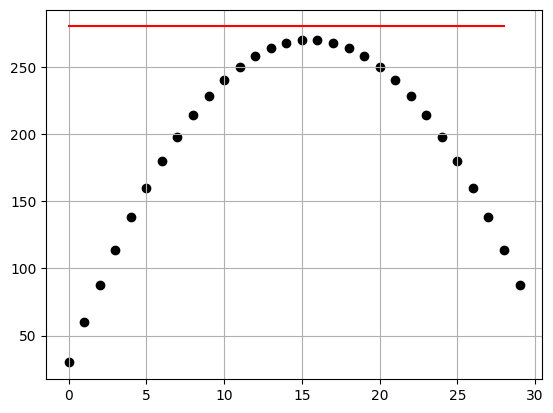

In [9]:
for w in range(p-1):
    plt.scatter(w, w*p - w**2 + p - 1, color='k')

plt.plot([x for x in range(w)], [280 for x in range(w)], color='r')
plt.grid()
plt.show()

In [169]:
def get_FHSsequence(p, w, a, k):
    fhs = []
    for i in range(p-1):
        fhs.append( sum( [(a**i + j) % p for j in range(k, k+w)] ) +k)

    return fhs


def get_WGFHSset(p, w, a, d):
    FHSset = np.array([get_FHSsequence(p, w, a, k) for k in range(p)])
    WGFHSset = []
    for b in FHSset:
        if get_min_gap(b) >= d:
            WGFHSset.append(b)

    return np.array(WGFHSset)

In [170]:
a = 3
w = 15
d = 8
WGFHSset = get_WGFHSset(p, w, a, d)

In [171]:
print(WGFHSset.shape)
print(f"family avg cross HC = {round(avg_crossHC(WGFHSset),5)}")
print(f"family avg auto HC = {round(avg_autoHC(WGFHSset),5)}")
print(f"family max HC = {round(avg_maxHC(WGFHSset),5)}")

(10, 30)
family avg cross HC = 0.08519
family avg auto HC = 0.0
family max HC = 0.81818


In [178]:
a = 24
WGFHSset = get_WGFHSset(p, w, a, d)
print(WGFHSset.shape)
print(f"family avg cross HC = {round(avg_crossHC(WGFHSset),5)}")
print(f"family avg auto HC = {round(avg_autoHC(WGFHSset),5)}")
print(f"family max HC = {round(avg_maxHC(WGFHSset),5)}")

(7, 30)
family avg cross HC = 0.11587
family avg auto HC = 0.0
family max HC = 0.75


---

In [192]:
def get_FHSsequence2(p, w, k):
    fhs = []
    for i in range(p):
        fhs.append( sum( [(j*k) % p for j in range(i, i+w)] ) )

    return fhs


def get_WGFHSset2(p, w, d):
    FHSset = np.array([get_FHSsequence2(p, w, k) for k in range(1,p)])
    WGFHSset = []
    for b in FHSset:
        if get_min_gap(b) >= d:
            WGFHSset.append(b)

    return np.array(WGFHSset)

In [193]:
p = 17
w = 7
d = 0
WGFHSset = get_WGFHSset2(p, w, d)


In [195]:
for b in WGFHSset:
    print(get_min_gap(b), b)

7 [21 28 35 42 49 56 63 70 77 84 91 81 71 61 51 41 31]
3 [42 56 70 67 64 61 58 55 52 49 63 60 57 54 51 48 45]
4 [46 50 54 58 62 66 53 57 61 65 69 56 43 47 51 55 59]
6 [50 61 72 66 60 54 65 59 53 47 58 52 46 40 51 62 56]
1 [54 55 56 57 58 59 60 61 62 63 64 48 49 50 51 52 53]
8 [41 49 57 48 56 64 55 63 71 62 70 61 52 60 51 42 50]
2 [45 60 58 56 54 52 67 65 63 61 59 57 55 53 51 49 47]
5 [66 71 76 64 69 57 62 50 55 43 48 36 41 46 51 56 61]
5 [36 48 43 55 50 62 57 69 64 76 71 66 61 56 51 46 41]
2 [57 59 61 63 65 67 52 54 56 58 60 45 47 49 51 53 55]
8 [61 70 62 71 63 55 64 56 48 57 49 41 50 42 51 60 52]
1 [48 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49]
6 [52 58 47 53 59 65 54 60 66 72 61 50 56 62 51 40 46]
4 [56 69 65 61 57 53 66 62 58 54 50 46 59 55 51 47 43]
3 [60 63 49 52 55 58 61 64 67 70 56 42 45 48 51 54 57]
7 [81 91 84 77 70 63 56 49 42 35 28 21 31 41 51 61 71]


In [196]:

print(WGFHSset.shape)
print(f"family avg cross HC = {round(avg_crossHC(WGFHSset),5)}")
print(f"family avg auto HC = {round(avg_autoHC(WGFHSset),5)}")
print(f"family max HC = {round(avg_maxHC(WGFHSset),5)}")

(16, 17)
family avg cross HC = 0.54902
family avg auto HC = 0.0
family max HC = 0.88235


In [24]:
y = int(0x41)
y

65

In [18]:
y

33